In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

In [2]:
output_dirs = ['/ihme/costeffectiveness/results/vivarium_gates_bep/lbwsg_acmr/india/2020_02_24_01_05_37/count_data/',
               '/ihme/costeffectiveness/results/vivarium_gates_bep/lbwsg_acmr/mali/2020_02_24_01_07_25/count_data/',
               '/ihme/costeffectiveness/results/vivarium_gates_bep/lbwsg_acmr/pakistan/2020_02_24_01_08_41/count_data/',
               '/ihme/costeffectiveness/results/vivarium_gates_bep/lbwsg_acmr/tanzania/2020_02_24_01_10_34/count_data/']

locations = ['India','Mali','Pakistan','Tanzania']

In [22]:
acmr = pd.DataFrame()
for i in list(range(len(output_dirs))):
    deaths = pd.read_hdf(output_dirs[i] + 'deaths.hdf')
    deaths = (deaths.where(deaths['scenario'] == 'baseline').dropna()
              .groupby(['input_draw','age_group'], as_index=False).sum()
              .rename(columns={'value':'deaths'}))
    pt = pd.read_hdf(output_dirs[i] + 'person_time.hdf')
    pt = (pt.where(pt['scenario'] == 'baseline').dropna()
          .groupby(['input_draw','age_group'], as_index=False).sum()
          .rename(columns={'value':'person_time'}))
    data = deaths.merge(pt, right_on=['input_draw','age_group'],
               left_on=['input_draw','age_group'])
    data['cause_specific_mortality_rate'] = data['deaths'] / data['person_time']
    data = data.groupby('age_group', as_index=False).mean()
    data['location'] = locations[i]
    acmr = acmr.append(data)
acmr = acmr.sort_values(by='location').drop(columns=['input_draw','person_time','deaths'])
acmr.head()

,age_group,cause_specific_mortality_rate,location
0,1_to_4,0.001457,India
1,1mo_to_6mo,0.011902,India
2,6mo_to_1,0.011795,India
3,early_neonatal,0.904054,India
4,late_neonatal,0.059193,India


In [9]:
# define function to load data from artifact for a specified cause and measure
# this function is called in the next function below

def load_artifact_data(cause, measure):
    master_art_data = pd.DataFrame()
    for i in ['india','mali','pakistan','tanzania']:
        art = Artifact('/share/costeffectiveness/artifacts/vivarium_gates_bep/' + i + '.hdf', 
                   filter_terms=['year_start == 2017', 'age_start < 5'])
        data = art.load('cause.' + cause + '.' + measure)
        data = pd.DataFrame(data.mean(axis=1)).reset_index().rename(columns={0:'value'})
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['age_group'] = 0
        data['age_group'] = np.where(data['age_start'] == 0, 'early_neonatal', 
                                   np.where(data['age_end'] == 1, '1mo_to_6mo',
                                            np.where(data['age_start'] == 1, '1_to_4', 
                                                    'late_neonatal')))
        master_art_data = master_art_data.append(data)
    return master_art_data

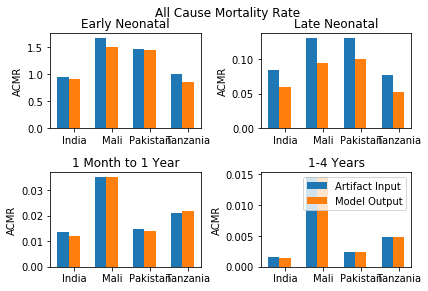

In [37]:
model_data = acmr
artifact_data = art_acmr

barWidth = 0.3
fig,axs = plt.subplots(2,2)
model = model_data['cause_specific_mortality_rate'].where(model_data['age_group'] == 'early_neonatal').dropna()
gbd = artifact_data['value'].where(artifact_data['age_group'] == 'early_neonatal').dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,0].bar(a, gbd, width=barWidth)
axs[0,0].bar(b, model, width=barWidth)
axs[0,0].set_title('Early Neonatal')
model = model_data['cause_specific_mortality_rate'].where(model_data['age_group'] == 'late_neonatal').dropna()
gbd = artifact_data['value'].where(artifact_data['age_group'] == 'late_neonatal').dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[0,1].bar(a, gbd, width=barWidth)
axs[0,1].bar(b, model, width=barWidth)
axs[0,1].set_title('Late Neonatal')
model = model_data['cause_specific_mortality_rate'].where(model_data['age_group'] == '1mo_to_6mo').dropna()
gbd = artifact_data['value'].where(artifact_data['age_group'] == '1mo_to_6mo').dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,0].bar(a, gbd, width=barWidth)
axs[1,0].bar(b, model, width=barWidth)
axs[1,0].set_title('1 Month to 1 Year')
model = model_data['cause_specific_mortality_rate'].where(model_data['age_group'] == '1_to_4').dropna()
gbd = artifact_data['value'].where(artifact_data['age_group'] == '1_to_4').dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
axs[1,1].bar(a, gbd, width=barWidth)
axs[1,1].bar(b, model, width=barWidth)
axs[1,1].set_title('1-4 Years')
plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
         xticklabels=np.unique(model_data['location']))
for ax in axs.flat:
    ax.set(ylabel='ACMR')
plt.legend(['Artifact Input','Model Output'])
plt.suptitle('All Cause Mortality Rate',x=0.55, y=1)
plt.subplots_adjust(right=1.7, top=1.5)
plt.tight_layout()